In [15]:
import os
import fnmatch

directory = "./"
search_string = "testfile_2023-11-11-14:49:07_random_forest"

matching_files = []

for filename in os.listdir(directory):
    if fnmatch.fnmatch(filename, f"*{search_string}*"):
        matching_files.append(filename)

print("Matching files:")
for file in matching_files:
    print(file)

Matching files:
testfile_2023-11-11-14:49:07_random_forest


In [16]:
with open(matching_files[-1], 'r') as file:
    content = file.readlines()

In [17]:
import numpy as np

content = [[float(x) for x in row.split(',')[:-1]] for row in content]

matrix = np.asarray(content[1:])

In [20]:
mean_weights = matrix.mean(axis=0)

In [25]:
%matplotlib inline

(array([  8.,   8.,   4.,  11.,   9.,   6.,   3.,   4.,   1.,   5.,  10.,
          1.,   4.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
          1.,   1.,   0.,   4.,   1.,   7.,   8.,   4.,   4.,   2.,   2.,
          5.,   4.,   3.,   5.,   1., 126.]),
 array([0.01581273, 0.03549648, 0.05518022, 0.07486397, 0.09454771,
        0.11423146, 0.1339152 , 0.15359895, 0.1732827 , 0.19296644,
        0.21265019, 0.23233393, 0.25201768, 0.27170142, 0.29138517,
        0.31106891, 0.33075266, 0.3504364 , 0.37012015, 0.38980389,
        0.40948764, 0.42917139, 0.44885513, 0.46853888, 0.48822262,
        0.50790637, 0.52759011, 0.54727386, 0.5669576 , 0.58664135,
        0.60632509, 0.62600884, 0.64569258, 0.66537633, 0.68506007,
        0.70474382, 0.72442757, 0.74411131, 0.76379506, 0.7834788 ,
        0.80316255, 0.82284629, 0.84253004, 0.86221378, 0.88189753,
        0.90158127, 0.92126502, 0.94094876, 0.

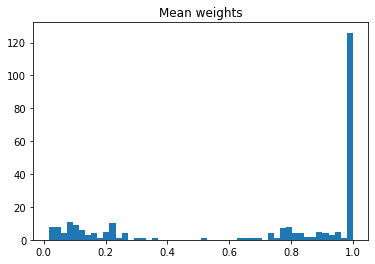

In [26]:
import matplotlib.pyplot as plt

plt.title("Mean weights")
plt.hist(mean_weights, bins=50)

In [29]:
mean_weights = [x if x != 1 else 0.999999 for x in mean_weights]

### Fit beta function to average values

In [30]:
from scipy.stats import beta
a, b, loc, scale = beta.fit(mean_weights, floc=0, fscale=1)

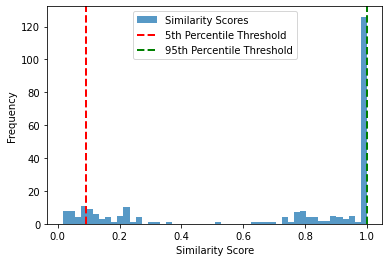

Lower threshold: 0.09165973884344332
Prototypes to prune below the lower threshold: [  1  16  19  24  36  38  39  41  48  55  76  93 101 103 117 118 119 136
 137 138 139 152 187 192 193 204 217 218 224 234 246]
Upper threshold: 0.9999999982031549
Prototypes to prune above the upper threshold: [ 25  29  43  65  66  72 112 154 194 207]


In [31]:
# Determine the 5th percentile threshold using the fitted Beta distribution.
# Prototypes with similarity scores below this threshold are less informative or outliers and can be pruned.
lower_threshold = beta.ppf(0.10, a, b, loc, scale)

# Determine the 95th percentile threshold using the fitted Beta distribution.
# Prototypes with similarity scores above this threshold are too common and can also be pruned.
upper_threshold = beta.ppf(0.90, a, b, loc, scale)

# Identify the pairwise comparison indices to prune based on the lower threshold.
lower_to_prune_indices = np.where(mean_weights < lower_threshold)[0]

# Identify the pairwise comparison indices to prune based on the upper threshold.
upper_to_prune_indices = np.where(mean_weights > upper_threshold)[0]

# Plot the histogram of the similarity scores with the pruning thresholds indicated.
plt.hist(mean_weights, bins=50, alpha=0.75, label='Similarity Scores')
plt.axvline(lower_threshold, color='r', linestyle='dashed', linewidth=2, label='5th Percentile Threshold')
plt.axvline(upper_threshold, color='g', linestyle='dashed', linewidth=2, label='95th Percentile Threshold')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Output the thresholds and the indices of pairwise comparisons that are candidates for pruning.
print(f'Lower threshold: {lower_threshold}')
print(f'Prototypes to prune below the lower threshold: {lower_to_prune_indices}')
print(f'Upper threshold: {upper_threshold}')
print(f'Prototypes to prune above the upper threshold: {upper_to_prune_indices}')

## Visualize dropped and kept prototypes

In [19]:
from proto_drop_vis import visualize_topk_dropped
import os

cwd = os.getcwd()

proto_dropped  = list(set(lower_to_prune_indices).union(upper_to_prune_indices))
proto_kept = list(set(range(0, len(mean_weights))).difference(set(proto_dropped)))
LOG_DIR = os.path.join(cwd, "runs/plankton_test_2023_11_11_1445_258_protos_full_vis")
PATH_TRAINED_MODEL =  os.path.join(cwd, "runs/plankton_258_protos/checkpoints/net_trained_60")
to_sample  = 10

In [20]:
visualize_topk_dropped(proto_dropped, proto_kept, LOG_DIR, PATH_TRAINED_MODEL, 'dropped_kept_protos_258_beta_pruning', k=10, to_sample=to_sample,  num_features=258)

CUDA device set without id specification
Device used:  cuda with id [0]
Number of prototypes set from 768 to 258 . Extra 1x1 conv layer added. Not recommended.
chosen network is convnext
Pretrained network loaded
Num classes (k) =  86 ['Amphidinium_sp', 'Asterionellopsis', 'Cerataulina', 'Cerataulina_flagellate', 'Ceratium'] etc.
Visualizing prototypes for topk...


/sw/arch/RHEL8/EB_production/2022/software/PyTorch/1.12.0-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

0 prototypes do not have any similarity score > 0.1. Will be ignored in visualisation.



Visualizing topk: 100% 3096/3096 [00:37<00:00, 81.95it/s]

Abstained:  0


###  Inspect similarty scores for hand pick all grey prototypes

In [42]:
# Get the mean weights of specifically selected grey prototypes
grey_prototypes = [0, 11, 15, 40, 50, 60, 70, 71, 75]
mean_weights_grey_prototypes = {idx: x for idx, x in enumerate(mean_weights) if idx in grey_prototypes}

In [43]:
mean_weights_grey_prototypes

{0: 0.9999989824999997,
 11: 0.999999,
 15: 0.9999999888953486,
 40: 0.999999,
 50: 0.9999996088081393,
 60: 0.14377550119308347,
 70: 0.9999999522674419,
 71: 0.13100341398342613,
 75: 0.9999997240697663}

In [32]:
# Most important prototype
index =  np.where(mean_weights == max(mean_weights))[0]

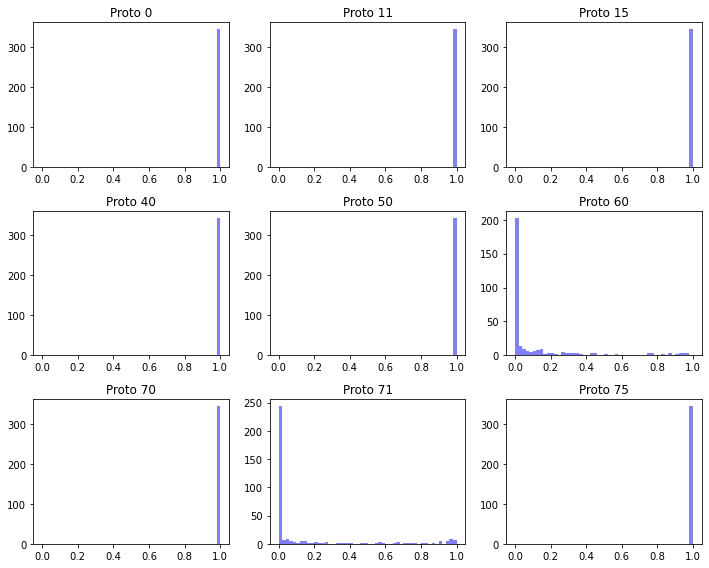

In [52]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

for idx, proto in enumerate(grey_prototypes):
    data = matrix[:, proto]
    axs[idx//3, idx%3].hist(data, bins=50, alpha=0.5, color='blue', range=(0,1))
    axs[idx//3, idx%3].set_title(f'Proto {proto}')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### Try the same but with not grey prototypes 

In [47]:
useful_prototypes = [9, 13, 14, 29, 67, 107, 128, 156, 241]
mean_weights_useful_prototypes = {idx: x for idx, x in enumerate(mean_weights) if idx in useful_prototypes}

In [48]:
mean_weights_useful_prototypes

{9: 0.9999995713662788,
 13: 0.9999998118895344,
 14: 0.8193896747827915,
 29: 0.9999999986046512,
 67: 0.8403902051598834,
 107: 0.999999398052325,
 128: 0.999994146104651,
 156: 0.23948477996442302,
 241: 0.8892870655377907}

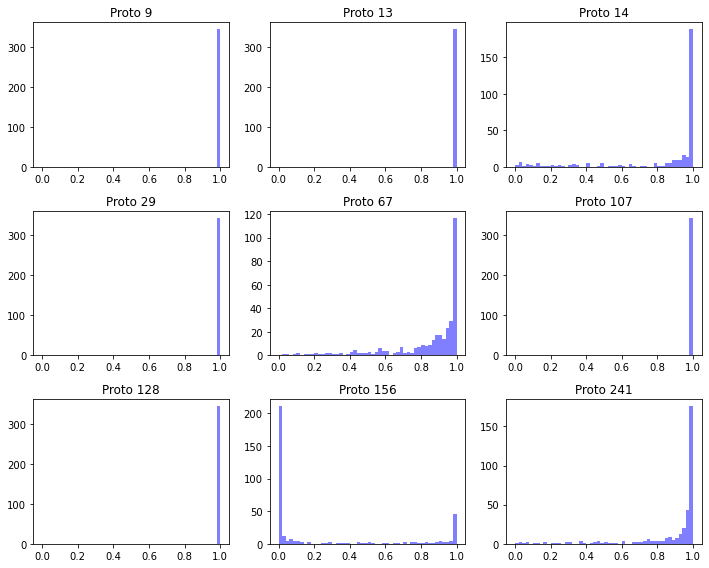

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

for idx, proto in enumerate(useful_prototypes):
    data = matrix[:, proto]
    axs[idx//3, idx%3].hist(data, bins=50, alpha=0.5, color='blue', range=(0,1))
    axs[idx//3, idx%3].set_title(f'Proto {proto}')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()